# Table of Contents
 <p>

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import numpy as np
import numpy.random as rnd
from scipy.special import expit

import seaborn as sns
import matplotlib.pyplot as plt

from util import trunc_norm

In [26]:
n  = 10   # number of clients in the group
n_ = 10   # number of clients in the other group

N =  6    # 10**N number of samples

e1 = 0.25
e2 = 0.5
a = expit(e1)
ee1 = np.exp(-e1)

b = 2. / e2

μ = n * a           # mean of the bernoulli (group size)
σ_b = a * (1 - a)   # variance of bernoulli (group perturbation)
σ_l = 2*(b**2)      # variance of laplace (value noise)

In [27]:
def gen_data(samples, n, n_, a, b):
    np.random.seed(1)

    A = np.ones((samples, n), dtype=int)
    B = np.zeros((samples, n_), dtype=int)
    g = np.concatenate((A, B), axis=1)

    vA = trunc_norm(loc=0., scale=0.33, size=n)
    vB = np.zeros(n_, dtype=float)
    v = np.concatenate((vA, vB))
    v = np.tile(v, (samples, 1))

    # DP protection
    new_g, new_v = g.copy(), v.copy()
    mask = rnd.binomial(1, 1 - a, size=g.shape).astype(bool)
    new_g[mask] = 1 - new_g[mask]
    new_v += rnd.laplace(loc=0.0, scale=b, size=v.shape)

    return np.ma.array(v, mask=1 - g), np.ma.array(new_v, mask=1 - new_g)

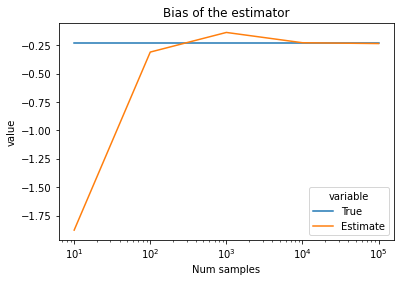

In [28]:
def exp(sample_exp):
    v, w = gen_data(10**sample_exp, n, n_, a, b)
    m = v.mean()
    for i in np.logspace(1, sample_exp - 1, sample_exp - 1, dtype=int):
        yield i, m, w[:i, :].mean(1).mean() / a

g = sns.lineplot(x='Num samples', y='value', hue='variable',
                 data=(pd.DataFrame(exp(N), columns=['Num samples', 'True', 'Estimate'])
                         .melt(id_vars='Num samples', value_vars=['True' , 'Estimate'])))
g.set(xscale='log', title='Bias of the estimator');

10.136700446471018 2.287619155147442
10.136700446471018 7.422190855996226
10.136700446471018 9.849682467219363
10.136700446471018 10.062271466111804
10.136700446471018 10.013604699293609


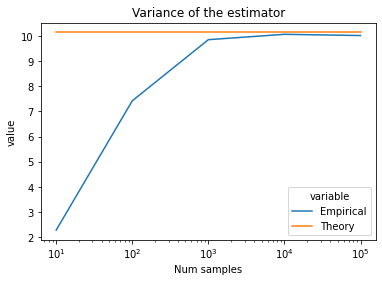

In [30]:
def exp(sample_exp):
    v, w = gen_data(10**sample_exp, n, n_, a, b)
    ν2 = np.square(v).mean(1).mean()
    ee_pol = (ee1**2) + (2 * ee1 + 1)
    est_var = (ν2 * ee1 + σ_l * ee_pol) / n
    for i in np.logspace(1, sample_exp - 1, sample_exp - 1, dtype=int):
        emp_var = (w[:i, :].sum(1) / (n * a)).var()
        print(est_var, emp_var)
        yield i, emp_var, est_var

g = sns.lineplot(x='Num samples', y='value', hue='variable',
                 data=(pd.DataFrame(exp(N), columns=['Num samples', 'Empirical', 'Theory'])
                         .melt(id_vars='Num samples', value_vars=['Empirical' , 'Theory'])))
g.set(xscale='log', title='Variance of the estimator');

In [31]:
v, w = gen_data(10**6, n, n_, a, b)
ν2 = np.square(v).mean(1).mean()
(w.sum(1) / (n * a)).var()

10.132453708907418